In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data_dir="C:\Machine_learning\Data"

In [10]:
os.listdir(data_dir)

['Happy face', 'Sad face']

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,batch_size=32)

Found 188 files belonging to 2 classes.


In [10]:
tf.keras.utils.image_dataset_from_directory??

In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
batch[0].max()

255.0

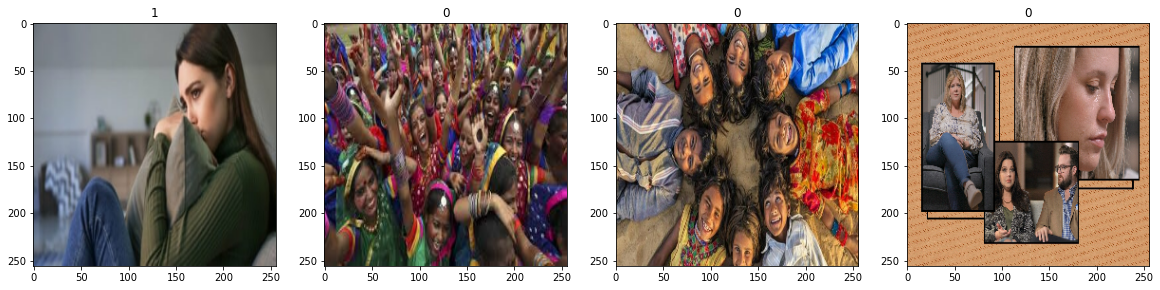

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()[0].max()

1.0

In [20]:
data.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

6

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [28]:
model=Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 2s/step - loss: 1.4746 - accuracy: 0.4844 - val_loss: 0.7709 - val_accuracy: 0.6875
Epoch 2/20
4/4 [==============================] - 10s 2s/step - loss: 0.7828 - accuracy: 0.5156 - val_loss: 0.6681 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 10s 2s/step - loss: 0.6734 - accuracy: 0.6641 - val_loss: 0.6804 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 10s 2s/step - loss: 0.6576 - accuracy: 0.7188 - val_loss: 0.6258 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 10s 2s/step - loss: 0.5988 - accuracy: 0.5469 - val_loss: 0.6052 - val_accuracy: 0.8438
Epoch 6/20
4/4 [==============================] - 10s 2s/step - loss: 0.5398 - accuracy: 0.8047 - val_loss: 0.5024 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 10s 2s/step - loss: 0.4887 - accuracy: 0.7578 - val_loss: 0.4644 - val_accuracy: 0.8750
Epoch 8/20
4/4 [==================

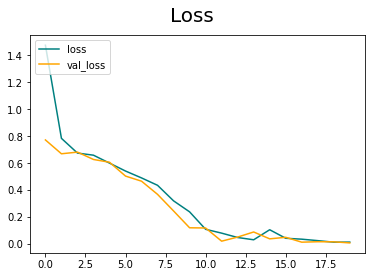

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

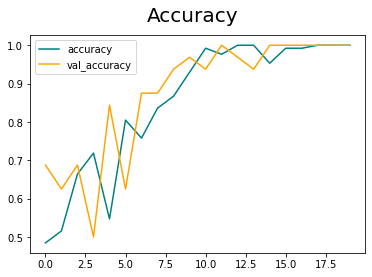

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 585ms/step


In [42]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


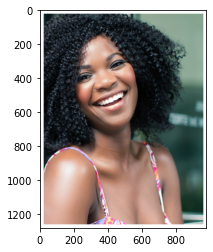

In [45]:
img=cv2.imread("C:\Machine_learning\Data\happy.jpg")
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

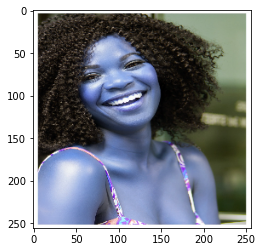

In [49]:
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
ypred=model.predict(np.expand_dims(resize/255,0))


1/1 [==============================] - 0s 64ms/step


In [57]:
if(ypred<0.5):
    print("Predict class is Happy")
else:
    print("Predict class is Sad")

Predict class is Happy


In [58]:
from tensorflow.keras.models import load_model 

In [59]:
model.save(os.path.join('C:\Machine_learning\model','SentimentalAnalyser'))

INFO:tensorflow:Assets written to: C:\Machine_learning\model\SentimentalAnalyser\assets


INFO:tensorflow:Assets written to: C:\Machine_learning\model\SentimentalAnalyser\assets


In [60]:
model2=load_model(os.path.join('C:\Machine_learning\model','SentimentalAnalyser'))

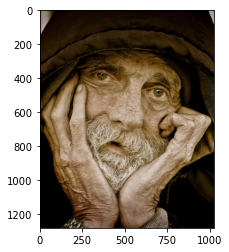

In [64]:
img1=cv2.imread('C:\Machine_learning\Data\sad.jpg')
plt.imshow( cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

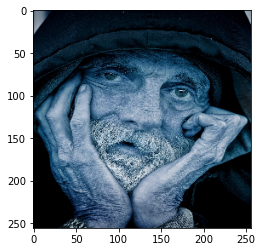

In [65]:
resize1=tf.image.resize(img,(256,256))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [66]:
ypred1=model2.predict(np.expand_dims(resize/255,0))
ypred1

1/1 [==============================] - 0s 168ms/step


array([[0.7887941]], dtype=float32)